# Executing DB-DOI on Quantinuum

This notebook showcases the DB-DOI workflow on Quantinum.

We will use XXZ with number of qubits given by

In [113]:
L= 10


1. We first run HVA with number of layers given by

In [115]:
p = 1

2. We then execute DB-DOI with total runtime of about 5 seconds. We then save to QASM the DB-DOI circuit for 1 and 2 steps.
2. We load from QASM the DB-DOI circuitm into Quantinuum's pytket and run a noiseless simulation in the pytket simulator.
3. To simulate the effect of noise, we execute on Quantinuum's emulator the same circuit as above.


## 1. Run HVA

In [117]:
from db_doi.utils_XXZ_compilation import *

niter = 0
print("---------------\n\n")
print(f"Initializing HVA training for L={L} and {p} layers.")
print(f"Will not run basinhopping." if niter == 0 else f"Will run basinhopping with {niter} iterations")

H_XXZ = XXZ_compilation_line(L,gateset="RZZ",delta=0.5)

data_collection = {}
E0,E1 = H_XXZ.eigenergies_ED()
print(f"The target energy is {E0} and the first excited eigenergy is {E1}")
data_collection["E0"] = E0
data_collection["E1"] = E1

print(f"\nRunning layer number {p} for system size L={L}")
HVA_circ, E_HVA, t_HVA = H_XXZ.find_XXZ_HVA_circuit(nlayers=p, please_use_basinhopping= niter)
data_collection[f"HVA_Nlayers_{p}"] = { "nlayers": p, "circuit": HVA_circ, "E_HVA": E_HVA, "t_HVA": t_HVA } 

from db_doi.utils_reporting import save_data, load_data
save_data(data_collection,  f"example_results/training_data/Quantinuum_Example_HVA_data_L_{L}_p_{p}")

---------------


Initializing HVA training for L=10 and 1 layers.
Will not run basinhopping.
The target energy is -14.361002811946227 and the first excited eigenergy is -13.437060121401537

Running layer number 1 for system size L=10
Initial loss: -12.99781066574181
Return from COBYLA because the trust region radius reaches its lower bound.
Number of function values = 41   Least value of F = -13.678712475310954
The corresponding X is: [0.51961652 0.29262347]

Final cost function:
-13.678712475310954
Parameters yielding final value:
[0.51961652 0.29262347]


In [118]:
from qibo import models
import os
HVA_qasm = models.Circuit.to_qasm(HVA_circ)
folder_path = "example_results/circuit_qasm/"
os.makedirs(folder_path, exist_ok=True)
with open(folder_path + "Quantinuum_Example_HVA_warm_start.qasm", "w") as file:
    file.write(HVA_qasm)

## 2. Run DB-DOI based on this warm-start

In [119]:

from db_doi.group_commutator_iteration import GroupCommutatorIteration, DoubleBracketRotationApproximationType

db_doi_warm_start_circuit = deepcopy(HVA_circ)

gci = GroupCommutatorIteration(deepcopy(H_XXZ), db_doi_warm_start_circuit, DoubleBracketRotationApproximationType.group_commutator_reduced )
print(gci.loss(), E_HVA, E0)
print(gci.double_bracket_rotation_approximation_type)
from collections import Counter


class DOI_magnetic_field(hamiltonians.SymbolicHamiltonian):
    def __init__(self, L):        
        super().__init__(sum([Z(i) for i in range(L)]))        
        self.gateset = "RZZ"        
    
    def circuit(self,t):
            import qibo
            c = qibo.Circuit(L)
            for i in range(L):
                c.add(qibo.gates.RZ(i, t))
            return c
doi = DOI_magnetic_field(L)

doi.circuit(1).draw()

-13.678712475310954 -13.678712475310954 -14.361002811946227
DoubleBracketRotationApproximationType.group_commutator_reduced
0: ─RZ─
1: ─RZ─
2: ─RZ─
3: ─RZ─
4: ─RZ─
5: ─RZ─
6: ─RZ─
7: ─RZ─
8: ─RZ─
9: ─RZ─


In [120]:

gci_results = {}
from db_doi.utils_reporting import two_qubit_counter
db_doi_two_qubit_counts = [ two_qubit_counter(db_doi_warm_start_circuit) ]
db_doi_energies =  [ gci.loss() ]
db_doi_circuits = [deepcopy(db_doi_warm_start_circuit)]

gci.loss(0.05, doi)

np.float64(-13.747616462052285)

--------------------------
Step 1
Step grid: [0.02       0.06666667 0.11333333 0.16       0.20666667 0.25333333
 0.3       ]
Losses: [np.float64(-13.680084133631217), np.float64(-13.781872920284817), np.float64(-13.849867493800696), np.float64(-13.87366467413601), np.float64(-13.855716754808359), np.float64(-13.799580385711318), np.float64(-13.708313370898125)]
Optimal step: 0.15999999999999998
Minimum loss: -13.87366467413601


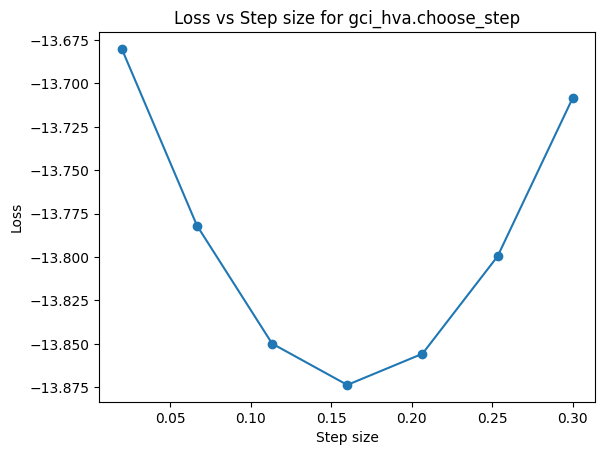

In [121]:

print("--------------------------")
print(f"Step 1")   

step_grid = np.linspace(0.02, 0.3, 7)
s_opt, loss_min, losses, _ = gci.choose_step(
    doi, step_grid=step_grid)
print("Step grid:", step_grid)
print("Losses:", losses)
print(f"Optimal step: {s_opt}")
print(f"Minimum loss: {loss_min}")
plt.figure()
plt.plot(step_grid, losses, marker='o')
plt.xlabel('Step size')
plt.ylabel('Loss')
plt.title('Loss vs Step size for gci_hva.choose_step')
plt.show()

gci(s_opt, doi)

db_doi_two_qubit_counts.append( two_qubit_counter(gci.preparation_circuit))
db_doi_energies.append(gci.loss())
db_doi_circuits.append(deepcopy(gci.preparation_circuit))
db_doi_hva_results = {'energies': db_doi_energies, 
                'cz_counts': db_doi_two_qubit_counts, 
                'circuits': db_doi_circuits,
                's_opt': s_opt,
                'energy_step_1': gci.loss()}
save_data(db_doi_hva_results, f"example_results/training_data/Quantinuum_Example_DB-DOI_data_L_{L}_p_{p}_k_{1}")


In [122]:
from qibo import models
db_doi_1_qasm = models.Circuit.to_qasm(gci.preparation_circuit)
folder_path = "example_results/circuit_qasm/"
with open(folder_path+f"Quantinuum_Example_HVA_DB-DOI_k=1.qasm", "w") as file:
    file.write(db_doi_1_qasm)

We check that the energy is now optimal for GCI.

In [80]:
gci.loss(0, doi)

np.float64(-13.873664674134133)

## 3. Load warm-start and DB-DOI circuits into pytket

In [123]:
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
import pytket.qasm

folder_path = "example_results/circuit_qasm/"
warm_start_circ = pytket.qasm.circuit_from_qasm(folder_path+"Quantinuum_Example_HVA_warm_start.qasm")
db_doi_circ = pytket.qasm.circuit_from_qasm(folder_path+"Quantinuum_Example_HVA_DB-DOI_k=1.qasm")

Let us check the size of the DB-DOI circuit.

In [124]:
print("-------------warm-start-------------")
print("Circuit depth:", warm_start_circ.depth())
print("Circuit total gate count:", warm_start_circ.n_gates)
num_cnots = sum(1 for command in warm_start_circ if command.op.type == OpType.CX)
print("Circuit CNOT count:", num_cnots)
print("---------------DB-DOI---------------")
print("Circuit depth:", db_doi_circ.depth())
print("Circuit total gate count:", db_doi_circ.n_gates)
num_cnots = sum(1 for command in db_doi_circ if command.op.type == OpType.CX)
print("Circuit CNOT count:", num_cnots)

-------------warm-start-------------
Circuit depth: 21
Circuit total gate count: 155
Circuit CNOT count: 5
---------------DB-DOI---------------
Circuit depth: 92
Circuit total gate count: 680
Circuit CNOT count: 15


## Quantinuum preparation
Authentication - Create project - Set context

In [84]:
import qnexus as qnx

In [88]:
# connect to nexus account by changing 0 to 1 (usually logged in for about 1 month)
if 0:
    qnx.client.auth.login()

🌐 Browser log in initiated.


╭────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                        │
│         Confirm that the browser shows the following code and click 'allow device':    │
│                                                                                        │
│                                      4qIhwt                                            │
│                                                                                        │
╰────────────────────────────────────────────────────────────────────────────────────────╯

Browser didn't open automatically? Use this link: https://nexus.quantinuum.com/auth/device/browser?otp=4qIhwt4lW8EXuuMu_NLAHPG0kD13iPFCZbScPSIK5Ey7kjsAksSc2gYoJr0iDbpoj2czE8W7OWoOdrrqusAJMQ
✅ Successfully logged in as xiaoyue.li@ntu.edu.sg using the browser.


In [125]:
# connect to nexus project
project_name = "DB-DOI XXZ"
project_ref = qnx.projects.get_or_create(name=project_name)
project_ref.df()

# set this in the context
qnx.context.set_active_project(project_ref)

## Energy expectation

We define the loss function as the energy expectation of $H$ with the rotated state $|\psi\rangle=U|0\rangle$, where the $U$ is implemented via the boostwarm_start circuit.

We will start with computing the expectation of a Pauli operator measured in the corresponding basis.

In [126]:
from pytket import Circuit
from pytket.utils.operators import QubitPauliOperator
from pytket.partition import measurement_reduction, MeasurementBitMap, MeasurementSetup, PauliPartitionStrat
from pytket.backends.backendresult import BackendResult
from pytket.pauli import Pauli, QubitPauliString
from pytket.circuit import Qubit

In [127]:
def compute_expectation_paulistring(
    distribution: dict[tuple[int, ...], float], bitmap: MeasurementBitMap
) -> float:
    '''
    This function assumes that the bitmap is in the correct measurement basis
    and evaluates Pauli operators composed of Pauli.Z and Pauli.I.
    It calculates the expectation by counting the parity of the qubits being
    flipped.
    '''
    value = 0
    for bitstring, probability in distribution.items():
        value += probability * (sum(bitstring[i] for i in bitmap.bits) % 2)
    return ((-1) ** bitmap.invert) * (-2 * value + 1)

Combining with the measurement setup and count results, the loss function can be defined:

In [128]:
def compute_expectation_value_from_results(
    results: list[BackendResult],
    measurement_setup: MeasurementSetup,
    operator: QubitPauliOperator,
) -> float:
    '''
    This function loops with the measurement_setup corresponding to the
    hamiltonian, select the corresponding string_coef, results index and
    calculates the total expectation of the input hamiltonian.
    '''
    energy = 0
    for pauli_string, bitmaps in measurement_setup.results.items():
        string_coeff = operator.get(pauli_string, 0.0)
        if string_coeff != 0:
            for bm in bitmaps:
                index = bm.circ_index
                distribution = results[index].get_distribution()
                value = compute_expectation_paulistring(distribution, bm)
                energy += complex(value * string_coeff).real
    return energy

### Hamiltonian in Pytket

In [129]:
def create_qubit_pauli_string(nqubits, specify_ls, coef):
    '''
    specify_ls: {index:Pauli.X/Y/Z}
    '''
    term = {}
    specified_ids = list(specify_ls.keys())
    for i in range(nqubits):
        if i in specified_ids:
            term.update({Qubit(i):specify_ls[i]})
        else:
            term.update({Qubit(i):Pauli.I})

    return {QubitPauliString(term):coef}

In [130]:
# XXZ model
nqubits = L
delta = 0.5
terms = {}
# nqubits - 1 for open boundary condition
# nqubits for periodic boundary condition
for i in range(nqubits-1):
    term_x_i = create_qubit_pauli_string(nqubits, {i: Pauli.X, (i+1)%nqubits: Pauli.X}, 1)
    term_y_i = create_qubit_pauli_string(nqubits, {i: Pauli.Y, (i+1)%nqubits: Pauli.Y}, 1)
    term_z_i = create_qubit_pauli_string(nqubits, {i: Pauli.Z, (i+1)%nqubits: Pauli.Z}, delta)
    terms.update(term_x_i)
    terms.update(term_y_i)
    terms.update(term_z_i)
ham_quantinuum = QubitPauliOperator(terms)

### Measurement setup
Based on the hamiltonian in Pauli basis, we create a list of measurement setup for evaluating each non-commuting set of Pauli components of the hamiltonian.

In [131]:
terms = [term for term in ham_quantinuum._dict.keys()]
measurement_setup = measurement_reduction(
    terms, strat=PauliPartitionStrat.CommutingSets
)
# for mc in measurement_setup.measurement_circs:
#     render_circuit_jupyter(mc)

Here, we have created measurement circuits for the $X$, $Y$, and $Z$ terms. Next, we can upload and compile the measurement circuits.

## Compile circuits

We are now running noiseless emulation.

In [132]:
optimisation_level = 2

In [134]:
from datetime import datetime
# create list of circuits for measurement in different bases
warm_start_circuit_ref_list = []
db_doi_circuit_ref_list = []
for i, mc in enumerate(measurement_setup.measurement_circs):
    c = warm_start_circ.copy()
    c.append(mc)
    measurement_warm_start_circuit_ref = qnx.circuits.upload(
                circuit=c, 
                name=f"measurement warm-start circuit {i}",
            )
    c = db_doi_circ.copy()
    c.append(mc)
    measurement_db_doi_circuit_ref = qnx.circuits.upload(
                circuit=c, 
                name=f"measurement db_doi circuit {i}",
            )
    warm_start_circuit_ref_list.append(measurement_warm_start_circuit_ref)
    db_doi_circuit_ref_list.append(measurement_db_doi_circuit_ref)

# compile warm-start measurement circuit list
compiled_warm_start_circuit_refs = qnx.compile(
            name=f"compile_job_warm_start_{datetime.now()}",
            circuits=warm_start_circuit_ref_list,
            optimisation_level=optimisation_level,
            backend_config=qnx.QuantinuumConfig(device_name="H1-1LE"),
            timeout=None,
        )

# compile gci measurement circuit list
compiled_db_doi_circuit_refs = qnx.compile(
            name=f"compile_job_db_doi_{datetime.now()}",
            circuits=db_doi_circuit_ref_list,
            optimisation_level=optimisation_level,
            backend_config=qnx.QuantinuumConfig(device_name="H1-1LE"),
            timeout=None,
        )

## Run circuits

In [135]:
# Configuration
nshots = 2000
backend_config = qnx.QuantinuumConfig(device_name="H1-1LE") 

In [136]:
warm_start_job_name = f"execute_job_warm_start_{nshots}_shots_{datetime.now()}"
DB_DOI_job_name = f"execute_job_DB-DOI_{nshots}_shots_{datetime.now()}"
results_warm_start = qnx.start_execute_job(
            name=warm_start_job_name,
            circuits=compiled_warm_start_circuit_refs,
            n_shots=[nshots]*len(warm_start_circuit_ref_list),
            backend_config=backend_config,
        )
results_DB_DOI = qnx.start_execute_job(
            name=DB_DOI_job_name,
            circuits=compiled_db_doi_circuit_refs,
            n_shots=[nshots]*len(db_doi_circuit_ref_list),
            backend_config=backend_config,
        )

In [137]:
from pathlib import Path
folder_path = "example_results/qnx_job_ref/"
os.makedirs(folder_path, exist_ok=True)
qnx.filesystem.save(
    ref=results_warm_start,
    path=Path.cwd() / folder_path / warm_start_job_name,
    mkdir=True,
)

from pathlib import Path
qnx.filesystem.save(
    ref=results_DB_DOI,
    path=Path.cwd() /folder_path / DB_DOI_job_name,
    mkdir=True,
)

# Retrieve results

Without running repeated jobs, we can retrieve our results from the Qnexus project.

In [138]:
warm_start_job_file = folder_path + warm_start_job_name 
db_doi_job_file = folder_path + DB_DOI_job_name

In [139]:
from pathlib import Path
warm_start_job_ref = qnx.filesystem.load(
    path=Path.cwd() / warm_start_job_file
)

db_doi_job_ref = qnx.filesystem.load(
    path=Path.cwd() / db_doi_job_file
)

In [146]:
print(qnx.jobs.status(warm_start_job_ref))
print(qnx.jobs.status(db_doi_job_ref))

JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2025, 8, 15, 12, 16, 36, 937565, tzinfo=datetime.timezone.utc), queued_time=datetime.datetime(2025, 8, 15, 12, 15, 35, 252836, tzinfo=datetime.timezone.utc), submitted_time=datetime.datetime(2025, 8, 15, 12, 15, 9, 940000, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2025, 8, 15, 12, 16, 9, 237735, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)
JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2025, 8, 15, 12, 17, 54, 855512, tzinfo=datetime.timezone.utc), queued_time=datetime.datetime(2025, 8, 15, 12, 15, 35, 299995, tzinfo=datetime.timezone.utc), submitted_time=datetime.datetime(2025, 8, 15, 12, 15, 10, 439494, tzinfo=datetime.timezone.ut

In [147]:
warm_start_results = [job.download_result() for job in qnx.jobs.results(warm_start_job_ref)]
db_doi_results = [job.download_result() for job in qnx.jobs.results(db_doi_job_ref)]

Unknown OpType in BackendInfo: `%`, will omit from BackendInfo. Consider updating your pytket version.
Unknown OpType in BackendInfo: `%`, will omit from BackendInfo. Consider updating your pytket version.
Unknown OpType in BackendInfo: `%`, will omit from BackendInfo. Consider updating your pytket version.
Unknown OpType in BackendInfo: `%`, will omit from BackendInfo. Consider updating your pytket version.
Unknown OpType in BackendInfo: `%`, will omit from BackendInfo. Consider updating your pytket version.
Unknown OpType in BackendInfo: `%`, will omit from BackendInfo. Consider updating your pytket version.
Unknown OpType in BackendInfo: `%`, will omit from BackendInfo. Consider updating your pytket version.
Unknown OpType in BackendInfo: `%`, will omit from BackendInfo. Consider updating your pytket version.
Unknown OpType in BackendInfo: `%`, will omit from BackendInfo. Consider updating your pytket version.
Unknown OpType in BackendInfo: `%`, will omit from BackendInfo. Consider 

In [163]:
expval_warm_start = compute_expectation_value_from_results(
    warm_start_results, measurement_setup, ham_quantinuum
)
print(expval_warm_start)

-13.55999999999999


In [164]:
expval_db_doi = compute_expectation_value_from_results(
    db_doi_results, measurement_setup, ham_quantinuum
)
print(expval_db_doi)

-13.963999999999999


# With noise

In [198]:
backend_config_noise = qnx.QuantinuumConfig(
    device_name='H1-Emulator',
    attempt_batching=True,
)

In [199]:
warm_start_job_name_with_noise = f"execute_job_warm_start_{nshots}_shots_noise_{datetime.now()}"
DB_DOI_job_name_with_noise = f"execute_job_DB-DOI_{nshots}_shots_noise_{datetime.now()}"
results_warm_start_with_noise = qnx.start_execute_job(
            name=warm_start_job_name_with_noise,
            circuits=compiled_warm_start_circuit_refs,
            n_shots=[nshots]*len(warm_start_circuit_ref_list),
            backend_config=backend_config_noise,
        )
results_DB_DOI_with_noise = qnx.start_execute_job(
            name=DB_DOI_job_name_with_noise,
            circuits=compiled_db_doi_circuit_refs,
            n_shots=[nshots]*len(db_doi_circuit_ref_list),
            backend_config=backend_config_noise,
        )

In [204]:
from pathlib import Path
folder_path = "example_results/qnx_job_ref/"
os.makedirs(folder_path, exist_ok=True)
qnx.filesystem.save(
    ref=results_warm_start_with_noise,
    path=Path.cwd() / folder_path / warm_start_job_name_with_noise,
    mkdir=True,
)

from pathlib import Path
qnx.filesystem.save(
    ref=results_DB_DOI_with_noise,
    path=Path.cwd() /folder_path / DB_DOI_job_name_with_noise,
    mkdir=True,
)

### Load results with noise

In [205]:
warm_start_job_file_noise = folder_path + warm_start_job_name_with_noise
db_doi_job_file_noise = folder_path + DB_DOI_job_name_with_noise

In [206]:
warm_start_job_ref_noise = qnx.filesystem.load(
    path=Path.cwd() / warm_start_job_file_noise
)

db_doi_job_ref_noise = qnx.filesystem.load(
    path=Path.cwd() / db_doi_job_file_noise
)

In [211]:
print(qnx.jobs.status(warm_start_job_ref_noise))
print(qnx.jobs.status(db_doi_job_ref_noise))

JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2025, 8, 15, 12, 52, 22, 942419, tzinfo=datetime.timezone.utc), queued_time=datetime.datetime(2025, 8, 15, 12, 49, 35, 554527, tzinfo=datetime.timezone.utc), submitted_time=datetime.datetime(2025, 8, 15, 12, 49, 5, 633633, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2025, 8, 15, 12, 49, 35, 769703, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)
JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2025, 8, 15, 12, 52, 25, 545619, tzinfo=datetime.timezone.utc), queued_time=datetime.datetime(2025, 8, 15, 12, 49, 35, 582328, tzinfo=datetime.timezone.utc), submitted_time=datetime.datetime(2025, 8, 15, 12, 49, 6, 573145, tzinfo=datetime.timezone.ut

In [212]:
warm_start_results_noise = [job.download_result() for job in qnx.jobs.results(warm_start_job_ref_noise)]
db_doi_results_noise = [job.download_result() for job in qnx.jobs.results(db_doi_job_ref_noise)]

Unknown OpType in BackendInfo: `%`, will omit from BackendInfo. Consider updating your pytket version.
Unknown OpType in BackendInfo: `%`, will omit from BackendInfo. Consider updating your pytket version.
Unknown OpType in BackendInfo: `%`, will omit from BackendInfo. Consider updating your pytket version.
Unknown OpType in BackendInfo: `%`, will omit from BackendInfo. Consider updating your pytket version.
Unknown OpType in BackendInfo: `%`, will omit from BackendInfo. Consider updating your pytket version.
Unknown OpType in BackendInfo: `%`, will omit from BackendInfo. Consider updating your pytket version.
Unknown OpType in BackendInfo: `%`, will omit from BackendInfo. Consider updating your pytket version.
Unknown OpType in BackendInfo: `%`, will omit from BackendInfo. Consider updating your pytket version.
Unknown OpType in BackendInfo: `%`, will omit from BackendInfo. Consider updating your pytket version.
Unknown OpType in BackendInfo: `%`, will omit from BackendInfo. Consider 

In [213]:
expval_warm_start_noise = compute_expectation_value_from_results(
    warm_start_results_noise, measurement_setup, ham_quantinuum
)
print(expval_warm_start_noise)

-13.44699999999999


In [214]:
expval_db_doi_noise = compute_expectation_value_from_results(
    db_doi_results_noise, measurement_setup, ham_quantinuum
)
print(expval_db_doi_noise)

-13.583999999999985


# Prepare report

In [215]:
import qibo
from qibo.backends import construct_backend
from qibo import hamiltonians
import matplotlib.pyplot as plt
import numpy as np

In [216]:
qibo.set_backend("numpy")

[Qibo 0.2.21|INFO|2025-08-15 20:52:57]: Using numpy backend on /CPU:0


In [217]:
warm_start_circ_qibo = HVA_circ
db_doi_circ_qibo = gci.preparation_circuit

In [ ]:
def report(vqe_circ, gci_circ, hamiltonian, expval_vqe, expval_gci, expval_vqe_noise, expval_gci_noise):
    energies = hamiltonian.eigenvalues()
    ground_state_energy = float(energies[0])
    vqe_energy = float(hamiltonian.expectation(vqe_circ().state()))
    gci_energy = float(hamiltonian.expectation(gci_circ().state()))
    gap = float(energies[1] - energies[0])
    return (
        dict(
            nqubits=hamiltonian.nqubits,
            gci_energy=float(gci_energy),
            vqe_energy=float(vqe_energy),
            vqe_energy_emulator=float(expval_vqe),
            gci_energy_emulator=float(expval_gci),
            vqe_energy_emulator_noise=float(expval_vqe_noise),
            gci_energy_emulator_noise=float(expval_gci_noise),
            target_energy=ground_state_energy,
            diff_vqe_target=vqe_energy - ground_state_energy,
            diff_gci_target=gci_energy - ground_state_energy,
            diff_vqe_target_emulator=expval_vqe - ground_state_energy,
            diff_gci_target_emulator=expval_gci - ground_state_energy,
            diff_vqe_target_emulator_noise=expval_vqe_noise - ground_state_energy,
            diff_gci_target_emulator_noise=expval_gci_noise - ground_state_energy,
            gap=gap,
            diff_vqe_target_perc=abs(vqe_energy - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            diff_gci_target_perc=abs(gci_energy - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            diff_vqe_target_perc_emulator=abs(expval_vqe - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            diff_gci_target_perc_emulator=abs(expval_gci - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            diff_vqe_target_perc_emulator_noise=abs(expval_vqe_noise - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            diff_gci_target_perc_emulator_noise=abs(expval_gci_noise - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            fidelity_witness_vqe=1 - (vqe_energy - ground_state_energy) / gap,
            fidelity_witness_gci=1 - (gci_energy - ground_state_energy) / gap,
            fidelity_witness_vqe_emulator=1 - (expval_vqe - ground_state_energy) / gap,
            fidelity_witness_gci_emulator=1 - (expval_gci - ground_state_energy) / gap,
            fidelity_witness_vqe_emulator_noise=1 - (expval_vqe_noise - ground_state_energy) / gap,
            fidelity_witness_gci_emulator_noise=1 - (expval_gci_noise - ground_state_energy) / gap,
        )
    )

In [219]:
report_quantinuum = report(warm_start_circ_qibo, db_doi_circ_qibo, H_XXZ, expval_warm_start, expval_db_doi, expval_warm_start_noise, expval_db_doi_noise)

In [220]:
import pandas as pd

In [222]:
# Creating a DataFrame for the table
df = pd.DataFrame({
    "Analytical": [
        report_quantinuum['vqe_energy'],
        report_quantinuum['gci_energy'],
        report_quantinuum['diff_vqe_target'],
        report_quantinuum['diff_gci_target'],
        report_quantinuum['diff_vqe_target_perc'],
        report_quantinuum['diff_gci_target_perc'],
        report_quantinuum['fidelity_witness_vqe'],
        report_quantinuum['fidelity_witness_gci']
    ],
    "Emulator": [
        report_quantinuum['vqe_energy_emulator'],
        report_quantinuum['gci_energy_emulator'],
        report_quantinuum['diff_vqe_target_emulator'],
        report_quantinuum['diff_gci_target_emulator'],
        report_quantinuum['diff_vqe_target_perc_emulator'],
        report_quantinuum['diff_gci_target_perc_emulator'],
        report_quantinuum['fidelity_witness_vqe_emulator'],
        report_quantinuum['fidelity_witness_gci_emulator']
    ],
    "Emulator with Noise": [
        report_quantinuum['vqe_energy_emulator_noise'],
        report_quantinuum['gci_energy_emulator_noise'],
        report_quantinuum['diff_vqe_target_emulator_noise'],
        report_quantinuum['diff_gci_target_emulator_noise'],
        report_quantinuum['diff_vqe_target_perc_emulator_noise'],
        report_quantinuum['diff_gci_target_perc_emulator_noise'],
        report_quantinuum['fidelity_witness_vqe_emulator_noise'],
        report_quantinuum['fidelity_witness_gci_emulator_noise']
    ]
}, index=[
    "HVA energy",
    "DB-DOI energy",
    "Difference to target (HVA)",
    "Difference to target (DB-DOI)",
    "Percentage difference to target (HVA)",
    "Percentage difference to target (DB-DOI)",
    "Fidelity witness (HVA)",
    "Fidelity witness (DB-DOI)"
])

# Display the DataFrame
df

,Analytical,Emulator,Emulator with Noise
HVA energy,-13.678712,-13.560000,-13.447000
DB-DOI energy,-13.873665,-13.964000,-13.584000
Difference to target (HVA),0.682290,0.801003,0.914003
Difference to target (DB-DOI),0.487338,0.397003,0.777003
Percentage difference to target (HVA),4.750994,5.577625,6.364478
Percentage difference to target (DB-DOI),3.393483,2.764450,5.410505
Fidelity witness (HVA),0.261545,0.133060,0.010758
Fidelity witness (DB-DOI),0.472545,0.570317,0.159036
